In [1]:
import numpy
import corner
import emcee
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import scipy.optimize
import sys
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import scipy.optimize as op
from astropy.constants import c
import functions_polarization_MCMC as mcmc
import function_plots as mcmc_plots
from importlib import reload
import time
import tqdm 

import scipy.stats
import math

In [2]:
# Importing data:
path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_adapbox_rsl.fits'))[1].data

path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_polint = 'rmsynth_polint_1'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_polint+'.fits'))[0]
del hdu_polint.header['CROTA4']
data_polint = hdu_polint.data
wcs = WCS(hdu_polint.header)

savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

freqs = np.load('MKT_Freqs_mid.npy')

lamb = c.value/freqs

flux_measurements_I = np.load(savedir+'Abell85_BDSF_I.npy')
flux_measurements_Q = np.load(savedir+'Abell85_BDSF_Q.npy')
flux_measurements_U = np.load(savedir+'Abell85_BDSF_U.npy')
flux_unc_I = np.load(savedir+'Abell85_BDSF_unc_I.npy')
flux_unc_Q = np.load(savedir+'Abell85_BDSF_unc_Q.npy')
flux_unc_U = np.load(savedir+'Abell85_BDSF_unc_U.npy')
sources_phi = np.load(savedir+'Abell85_phi.npy')
mask = np.load(r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'+'Abell85_mask_5sigma10pix.npy')

I_select = flux_measurements_I[:,mask]
Q_select = flux_measurements_Q[:,mask]
U_select = flux_measurements_U[:,mask]
I_unc_select = flux_unc_I[:,mask]
Q_unc_select = flux_unc_Q[:,mask]
U_unc_select = flux_unc_U[:,mask]
phi_select = sources_phi[mask]
rsl_select = rsl[mask]

angles_select = 0.5*np.arctan2(U_select, Q_select)
angles_select_err = np.sqrt((Q_select*U_unc_select)**2 + (U_select*Q_unc_select)**2)/(2*(U_select**2 + Q_select**2))
linpol_select = np.sqrt(U_select**2 + Q_select**2)
linpol_select_err = (U_select*U_unc_select + Q_select*Q_unc_select)/linpol_select
p_select = linpol_select/I_select
p_select_err = p_select*np.sqrt((0*linpol_select_err/linpol_select)**2 + (I_unc_select/I_select)**2)

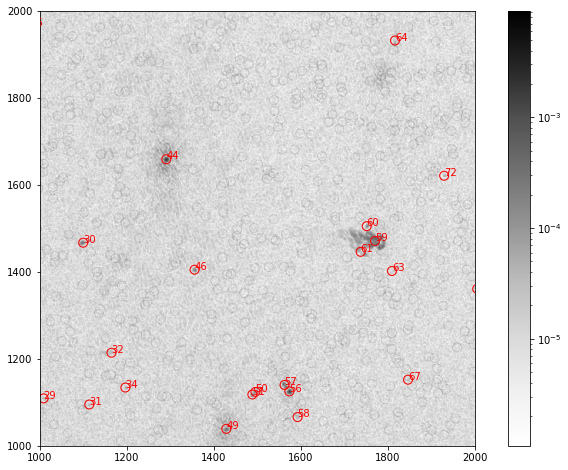

In [3]:
# Selecting the five sources that Erik Osinga also investigated as check:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)
plt.figure(figsize=(12,8))
a = plt.imshow(data_polint.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[mask,0], sources_pixpos[mask,1], s=80, facecolors='none', edgecolors='r')
for n in range(len(sources_pixpos[mask,0])):
    plt.text(sources_pixpos[mask,0][n], sources_pixpos[mask,1][n], str(n), color='red', clip_on=True)
plt.colorbar(a)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

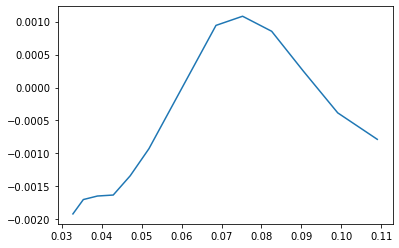

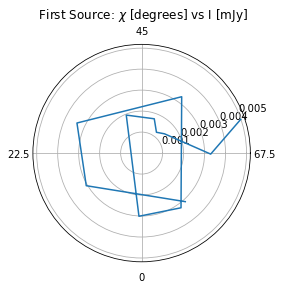

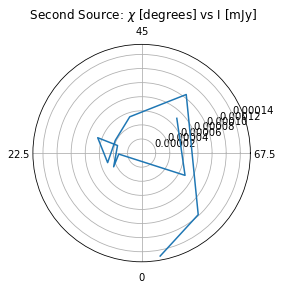

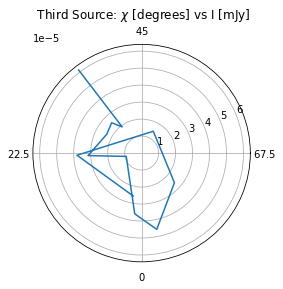

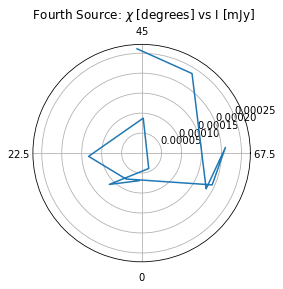

In [4]:
plt.plot(lamb**2, Q_select[:,44])
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,44], linpol_select[:,37])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" First Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,46], linpol_select[:,38])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Second Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,56], linpol_select[:,45])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Third Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles_select[:,57], linpol_select[:,46])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Fourth Source: $\chi$ [degrees] vs I [mJy]")
plt.show()



In [5]:
#So, we need the sources 44, 46, 56, 57:
mask_erik = np.zeros(len(I_select[0]), dtype=bool)
mask_erik[44]=True
mask_erik[46]=True
mask_erik[56]=True
mask_erik[57]=True

I_compar = I_select[:,mask_erik]
Q_compar = Q_select[:,mask_erik]
U_compar = U_select[:,mask_erik]
I_unc_compar = I_unc_select[:,mask_erik]
Q_unc_compar = Q_unc_select[:,mask_erik]
U_unc_compar = U_unc_select[:,mask_erik]
phi_compar = phi_select[mask_erik]
rsl_compar = rsl_select[mask_erik]

angles_compar = angles_select[:,mask_erik]
angles_compar_err = angles_select_err[:,mask_erik]
linpol_compar = linpol_select[:,mask_erik]
linpol_compar_err = linpol_select_err[:,mask_erik]
p_compar = p_select[:,mask_erik]
p_compar_err = p_select_err[:,mask_erik]

print(len(mask_erik))
print(np.argwhere(mask_erik))

132
[[44]
 [46]
 [56]
 [57]]


# Using Faraday MCMC functions script:

we look at source 56
20.0


Saving chain to /net/vdesk/data2/GoesaertW/Meerkat_Data/Achain_source_56_QU.npy
0.04630868185236343 289.8502758773323
The time of execution of above program is : 19.00497341156006


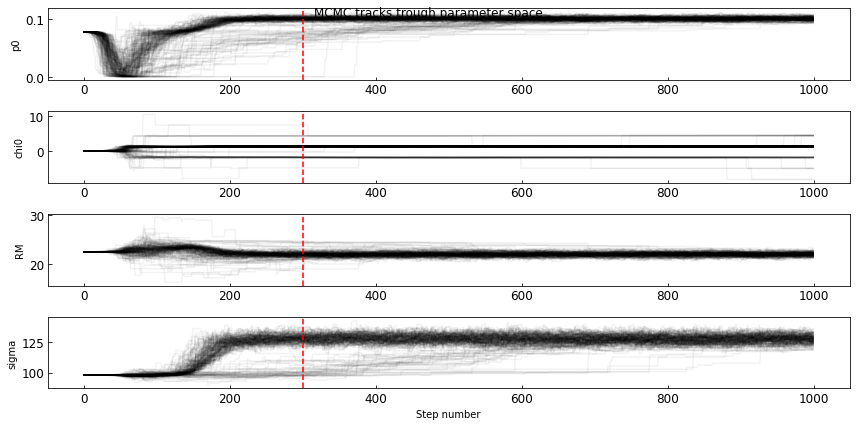

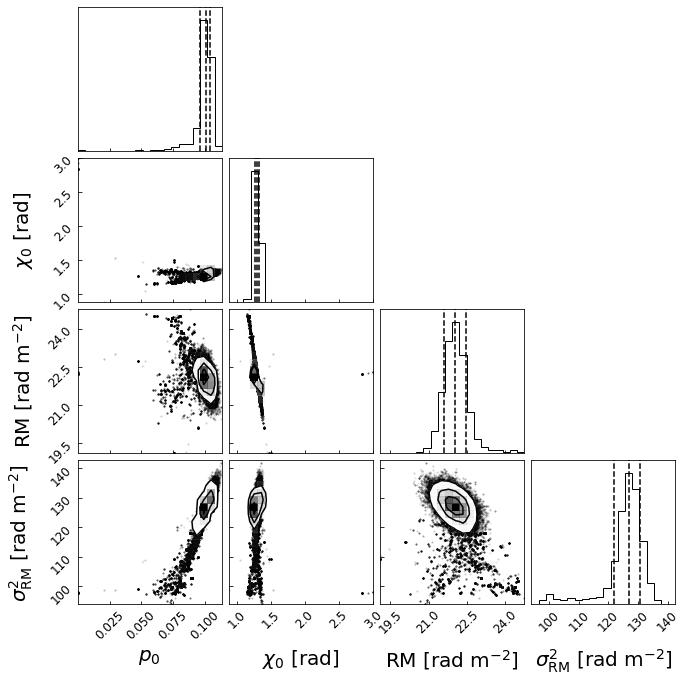

In [26]:
reload(mcmc)
reload(mcmc_plots)
start = time.time()

#We will look at one of the 4 sources:
source_compar = 1
source = 56#np.argwhere(mask_erik)[source_compar,0]
print('we look at source ' + str(source))
print(phi_select[source])
fit_dataI, fit_data, x, y = mcmc.polarization_fitting(lamb**2, I_select[:,source], I_unc_select[:,source]\
                        , Q_select[:,source], Q_unc_select[:,source], U_select[:,source], U_unc_select[:,source]\
                        , phi_select[source], rsl_select[source]['RA'], rsl_select[source]['DEC'], cornerplot=True,curvature=True\
                        ,sourcenum=source)
reduced_chi2 = mcmc_plots.models('ExtDepol', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1]\
                ,fit_data[0][1], fit_data[1][1], fit_data[2][1], fit_data[3][1], I_select[:,source]\
                , I_unc_select[:,source], Q_select[:,source], Q_unc_select[:,source], U_select[:,source]\
                , U_unc_select[:,source])
reduced_chi2_i = reduced_chi2[3]
reduced_chi2_qu = reduced_chi2[4]
print(reduced_chi2_i, reduced_chi2_qu)

end = time.time()
print("The time of execution of above program is :", end-start)

0.10084236275311245 1.2976688711574556 22.039913061711836 11.262804612090424


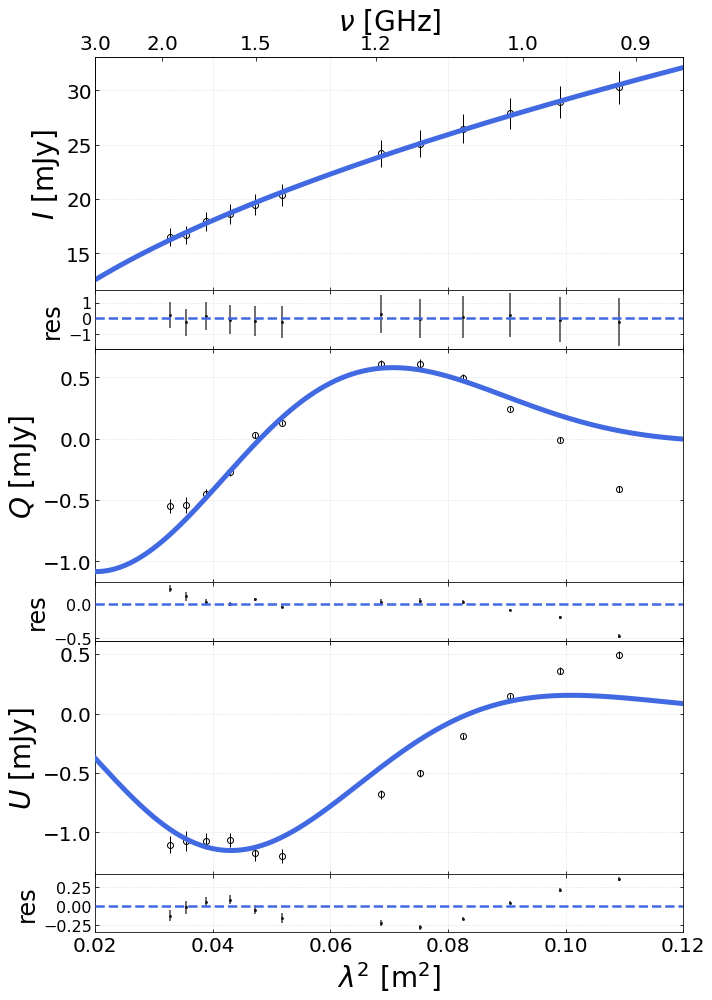

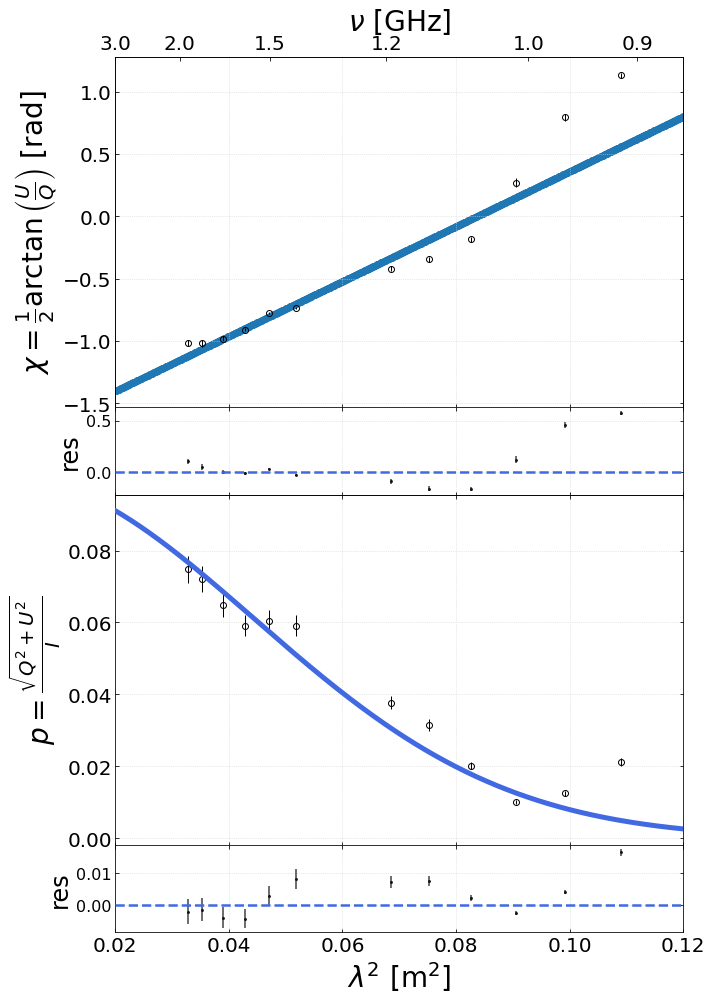

In [27]:
reload(mcmc_plots)
print(fit_data[0][1], fit_data[1][1], fit_data[2][1], np.sqrt(fit_data[3][1]))
mcmc_plots.plots('ExtDepol', 'depolfit_test', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1], fit_data[0][1]\
            , fit_data[1][1], fit_data[2][1], np.sqrt(fit_data[3][1]), I_select[:,source], I_unc_select[:,source]\
            , Q_select[:,source], Q_unc_select[:,source], U_select[:,source], U_unc_select[:,source]\
            , angles_select[:,source], angles_select_err[:,source], p_select[:,source]\
            , p_select_err[:,source], xlim=[0.02, 0.12], imgformat="pdf",saveplot=True)

# Repeat for all sources:

In [8]:
selectnum = len(rsl_select)
print(selectnum)
redchisq_I_list = np.zeros(selectnum)
redchisq_QU_list = np.zeros(selectnum)

norm_list = np.zeros((selectnum,3))
spix_list = np.zeros((selectnum,3))
curv_list = np.zeros((selectnum,3))
p0_list = np.zeros((selectnum,3))
chi0_list = np.zeros((selectnum,3))
RM_list = np.zeros((selectnum,3))
sigma_list = np.zeros((selectnum,3))

132


In [9]:
reload(mcmc)
reload(mcmc_plots)

for n in tqdm.tqdm(range(selectnum)):
    fit_dataI, fit_data, x, y = mcmc.polarization_fitting(lamb**2, I_select[:,n], I_unc_select[:,n]\
                        , Q_select[:,n], Q_unc_select[:,n], U_select[:,n], U_unc_select[:,n]\
                        , phi_select[n], rsl_select[n]['RA'], rsl_select[n]['DEC'], cornerplot=False,curvature=True\
                        , sourcenum=0)
    redchisq = mcmc_plots.models('ExtDepol', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1]\
                ,fit_data[0][1], fit_data[1][1], fit_data[2][1], fit_data[3][1], I_select[:,n]\
                , I_unc_select[:,n], Q_select[:,n], Q_unc_select[:,n], U_select[:,n], U_unc_select[:,n])

    redchisq_I_list[n] = redchisq[3]
    redchisq_QU_list[n] = redchisq[4]

    norm_list[n] = fit_dataI[0][1:]
    spix_list[n] = fit_dataI[1][1:]
    curv_list[n] = fit_dataI[2][1:]
    
    p0_list[n] = fit_data[0][1:]
    chi0_list[n] = fit_data[1][1:]
    RM_list[n] = fit_data[2][1:]
    sigma_list[n] = fit_data[3][1:]

directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
np.save(directory+'Abell85_mcmc_Inorm_free.npy', norm_list)
np.save(directory+'Abell85_mcmc_Ispix_free.npy', spix_list)
np.save(directory+'Abell85_mcmc_Icurv_free.npy', curv_list)
np.save(directory+'Abell85_mcmc_p0_free.npy', p0_list)
np.save(directory+'Abell85_mcmc_chi0_free.npy', chi0_list)
np.save(directory+'Abell85_mcmc_RM_free.npy', RM_list)
np.save(directory+'Abell85_mcmc_sigma_free.npy', sigma_list)
np.save(directory+'Abell85_mcmc_QUchisqw_free.npy', redchisq_QU_list)
np.save(directory+'Abell85_mcmc_Ichisqw_free.npy', redchisq_I_list)

 75%|███████▌  | 99/132 [23:11<07:59, 14.54s/it]/usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
100%|██████████| 132/132 [30:54<00:00, 14.05s/it]


In [10]:
np.save(directory+'Abell85_phi_rmsynth_selected.npy', phi_select)